<a href="https://colab.research.google.com/github/Papagoat/algo-trading-strategies/blob/main/Bollinger_SuperTrend_RSI_MACD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

In [36]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import yfinance as yf
import time
import requests
import io

In [37]:
end = datetime.now()
start = end - timedelta(days=7)
ticker = 'ETH-USD'
close = 'Close'

previous_price = 0
average_price = 0

# Download candlestick charts from Yahoo Finance

In [ ]:
df = yf.Ticker(ticker).history(period='5d', interval='2m')
df['Date'] = pd.to_datetime(df.index, format="%Y%m%d%H%M%S")
df['Minutes'] = df['Date'].dt.strftime('%M')
df['Seconds'] = df['Date'].dt.strftime('%S')
df = df[(df['Minutes'].astype(int) % 2 == 0) & (df['Seconds'] == '00')]
df.reset_index()

# Calculate MACD

In [39]:
def MACD(df):
    # Calculate the Short Term Exponential Moving Average
    ShortEMA = df[close].ewm(span=12, adjust=False).mean() #AKA Fast moving average

    # Calculate the Long Term Exponential Moving Average
    LongEMA = df[close].ewm(span=26, adjust=False).mean() #AKA Slow moving average

    # Calculate the Moving Average Convergence/Divergence (MACD)
    MACD = ShortEMA - LongEMA

    # Calculate the signal line
    signal = MACD.ewm(span=9, adjust=False).mean()

    df['MACD'] = MACD
    df['Signal Line'] = signal

    return df['MACD'], df['Signal Line']

# Calculate RSI

In [40]:
def RSI(df):
    df['price change'] = df[close].pct_change()
    df['Upmove'] = df['price change'].apply(lambda x: x if x > 0 else 0)
    df['Downmove'] = df['price change'].apply(lambda x: abs(x) if x < 0 else 0)
    df['Avg Up'] = df['Upmove'].ewm(span=19).mean()
    df['Avg Down'] = df['Downmove'].ewm(span=19).mean()
    df['RS'] = df['Avg Up']/df['Avg Down']
    df['RSI'] = df['RS'].apply(lambda x: 100 - (100/(x+1)))
    return df['price change'], df['Upmove'], df['Downmove'], df['Avg Up'], df['Avg Down'], df['RS'], df['RSI']

# Calculate Bollinger Bands

In [41]:
def BB(df):
    df['MA20'] = df[close].rolling(window=20).mean()
    df['20dSTD'] = df[close].rolling(window=20).std() 

    df['Upper'] = df['MA20'] + (df['20dSTD'] * 2)
    df['Lower'] = df['MA20'] - (df['20dSTD'] * 2)

    return df['MA20'], df['20dSTD'], df['Upper'], df['Lower']

# Calculate Supertrend

In [42]:
def tr(df):
    df['Previous Close'] = df[close].shift(1)
    df['High Low'] = abs(df['High'] - df['Low'])
    df['High Previous Close'] = abs(df['High'] - df['Previous Close'])
    df['Low Previous Close'] = abs(df['Low'] - df['Previous Close'])

    tr = df[['High Low', 'High Previous Close', 'Low Previous Close']].max(axis=1)

    return tr

In [43]:
def atr(df, period):
    df['TR'] = tr(df)
    atr = df['TR'].rolling(period).mean()

    return atr

In [44]:
def supertrend(df, period=7, atr_multiplier=3):
    hl2 = (df['High'] + df['Low']) / 2
    df['ATR'] = atr(df, period)
    df['SuperTrend Upper'] = hl2 + (atr_multiplier * df['ATR'])
    df['SuperTrend Lower'] = hl2 - (atr_multiplier * df['ATR'])
    df['SuperTrend In Uptrend'] = True

    for current in range(1, len(df.index)):
        previous = current - 1

        if df[close][current] > df['SuperTrend Upper'][previous]:
            df['SuperTrend In Uptrend'][current] = True
        elif df[close][current] < df['SuperTrend Lower'][previous]:
            df['SuperTrend In Uptrend'][current] = False
        else:
            df['SuperTrend In Uptrend'][current] = df['SuperTrend In Uptrend'][previous].copy()

            if df['SuperTrend In Uptrend'][current] and df['SuperTrend Lower'][current] < df['SuperTrend Lower'][previous]:
                df['SuperTrend Lower'][current] = df['SuperTrend Lower'][previous].copy()

            if not df['SuperTrend In Uptrend'][current] and df['SuperTrend Upper'][current] > df['SuperTrend Upper'][previous]:
                df['SuperTrend Upper'][current] = df['SuperTrend Upper'][previous].copy()
        
    return df

# Build DataFrame using indicators above

In [45]:
def build_dataframe(df):
    MACD(df)
    RSI(df)
    BB(df)
    supertrend(df)

    return df

# Calculate buy or sell signals

In [46]:
def buy_sell(df):
  sig_price_buy = []
  sig_price_sell = []
  sell = False

  sig_average_price = 0
  

  for i in range(len(df)):

    ## If Buy Signal
    if df['SuperTrend In Uptrend'][i] == True and df['MACD'][i] > df['Signal Line'][i] and 40 < df['RSI'][i] > 0:

      # If in Buy Phase
      if not sell:
        sig_price_buy.append(df[close][i])
        sig_price_sell.append(np.nan)
        sig_average_price = df[close][i]
        sell = True

      # If in Sell Phase
      else:
        sig_price_buy.append(np.nan)
        sig_price_sell.append(np.nan)

      # If in Sell Phase
    elif df['SuperTrend In Uptrend'][i] == False and df['MACD'][i] < df['Signal Line'][i] and 100 > df['RSI'][i] < 60 and sell:

      # If sell signal and close price is higher than average price
      if sig_average_price > 0 and sig_average_price * 1.05 < df[close][i]:
        sig_price_sell.append(df[close][i])
        sig_price_buy.append(np.nan)
        sig_average_price = 0
        sell = False
      elif sig_average_price > 0 and sig_average_price > df[close][i]:
      # If sell signal and average price is higher than close price
        sig_average_price = (sig_average_price + df[close][i]) / 2
        sig_price_buy.append(df[close][i])
        sig_price_sell.append(np.nan)
        sell = True
      else:
        sig_price_buy.append(np.nan)
        sig_price_sell.append(np.nan)

    # If in Buy Phase
    else:
      sig_price_buy.append(np.nan)
      sig_price_sell.append(np.nan)

  return(sig_price_buy, sig_price_sell)

In [ ]:
build_dataframe(df)
buy_sell = buy_sell(df)
df['Buy_Signal_Price'] = buy_sell[0]
df['Sell_Signal_Price'] = buy_sell[1]

# Plot MACD/RSI Chart

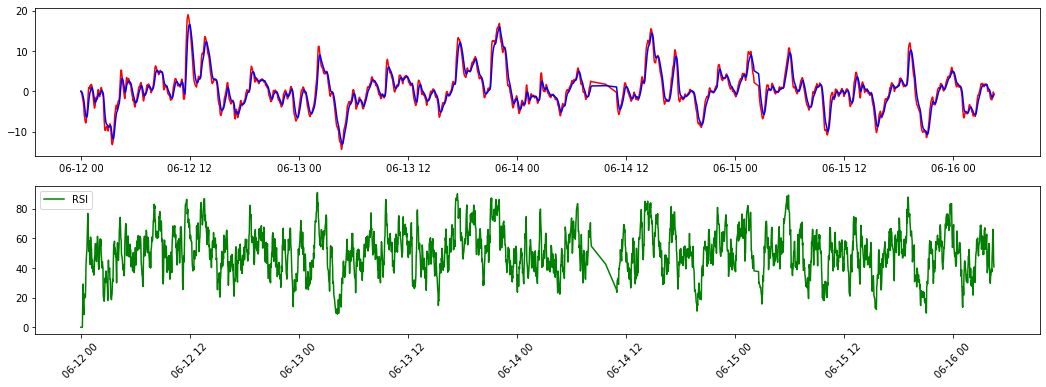

In [48]:
plt.figure(figsize=(18,6))
plt.subplot(211)
plt.plot(df.index, df['MACD'], label=f'{ticker} MACD', color = 'red')
plt.plot(df.index, df['Signal Line'], label='Signal Line', color='blue')
plt.subplot(212)
plt.plot(df.index, df['RSI'], label='RSI', color='green')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

# Plot Buy/Sell Chart

Text(0, 0.5, 'Price')

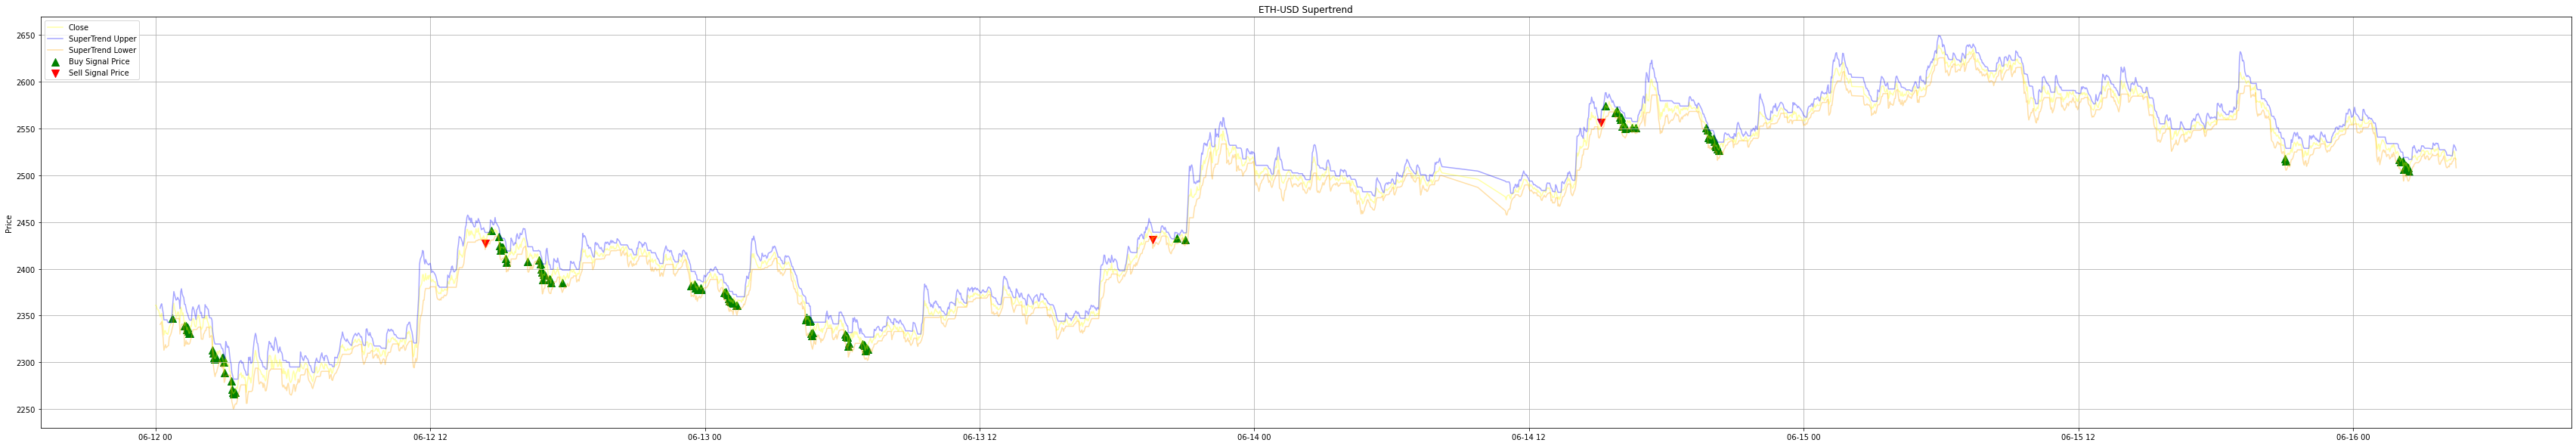

In [49]:
plt.figure(figsize=(60,10))
plt.scatter(df.index, df['Buy_Signal_Price'], label='Buy Signal Price', marker='^', color='green', s=100)
plt.scatter(df.index, df['Sell_Signal_Price'], label='Sell Signal Price', marker='v', color='red', s=100)

plt.plot(df.index, df[close], label=close, color = 'yellow', alpha=0.35)
plt.plot(df.index, df['SuperTrend Upper'], label='SuperTrend Upper', color = 'blue', alpha=0.35)
plt.plot(df.index, df['SuperTrend Lower'], label='SuperTrend Lower', color = 'orange', alpha=0.35)
plt.grid(True)
plt.title(f'{ticker} Supertrend')
plt.legend(loc='upper left')
plt.ylabel('Price')